# Welch Filter
- Here we try to understand the Welch filter in more detail so we know how to use it.
- It answers the question: **“How much power does my signal have at each frequency, in a stable and reliable way?”**
- If you do one FFT of a finite signal:
  - the estimate is noisy
  - it depends heavily on where your window starts/stops
- Welch’s idea:
  - Instead of trusting one FFT, take many small FFTs, then average their power.
- Averaging makes the estimate much smoother and more reliable.

In [1]:
# Importing functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

## Welch Filter Step-by-step
- Say you have some signal of length $N$

$$X = x[0], X[1], ..., x[n], ..., x[N-1] $$

- Step 1 is to break the signal into overlapping chunks:
  - Say let's use chunk length $L = 256$
  - Overlap them 50%
  - You would have:

```bash
segment 1: x[0 ... (L-1)]
segment 2: x[(L/2) ... (3L/2-1)]
segment 3: x[(L) ... (2L-1)]
```
  - Visually, you can imagine a segment window sliding over the input with 50% overlap.

- Step 2, multiply each segment by a smooth window (Hann window):

$$x_\textrm{segment}[n] \times w[n] $$

- Step 3, we apply an FFT for each chunk:
  - Compute FFT
  - Take magnitude squared to get power spectrum

```bash
Power spectrum 1
Power spectrum 2
Power spectrum 3
```

- Step 4, average the power spectra:
  - Average the power across all segments
  - This average is the **Power Spectral Density (PSD)** estimate

- Summary: **Welch is create many small FFTs then average their powers**

## Sample of Welch Filter
- Consider a sine wave 10 Hz signal samples at 100 Hz:

$$ x[n] = sin(2 \pi \cdot 10 \cdot n/100) $$

- We record 2 seconds and thus have 200 samples

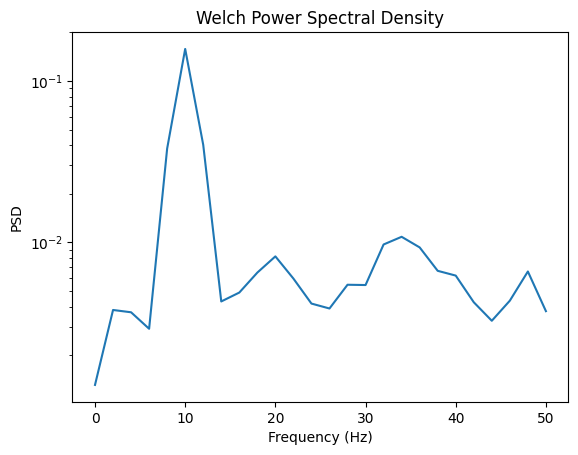

In [2]:
fs = 100.0  # Hz
t = np.arange(0, 2.0, 1/fs)
x = np.sin(2*np.pi*10*t) + 0.5*np.random.randn(len(t))

# Welch PSD
freqs, psd = welch(x, fs=fs, nperseg=50)

plt.semilogy(freqs, psd)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Welch Power Spectral Density")
plt.show()


## What is Hanning window?
- The problem with segmenting is that there can be discontinuous parts of the segment. For example, consider:

```bash
|        actual signal segment        |
x[0] ---------------------------- x[L-1]
```

- When we start to do an FFT on this segment, any FFT assumes that the segment is periodic. Therefore, it would see something like:

```bash
x[L-1] → x[0] → x[L-1] → x[0] → ...
```

- The problem is that `x[0]` and `x[L-1]` can be discontinuous and would introduce very sharp or high frequencies.
- That sudden jump creates **artificial high-frequency components**.
- This is also called **spectral leakage**
- So the Hanning window tries to smoothen the edges to reduce these frequencies. Such that instead of seeing a block like:

```bash
|████████████████████|
```

- We see a window like:
```
|   /\        /\    |
|  /  \      /  \   |
| /    \____/    \  |
```

- The Hann window equation is given by:

$$w[n] = 0.5 \left( 1 - \cos \left( \frac{2\pi n}{L-1} \right) \right), \ \ n=0, ..., L-1 $$

- There are some key properties:
  - $w[0] = 0$
  - $w[L-1] = 0$
  - Max value = 1 at the center
  - It has a smooth and continuous derivative

- Therefore in step 2 where $x_\textrm{segment}[n] \times w[n]$ happens, the signal is windowed by the Hann window
- Here's a numerical example, suppose you have a signal:

```bash
x[n]: 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
```

- Then the Hann window components `w[n]` would be (note that $L=8$):

```bash
n:    0     1     2     3     4     5     6     7
w[n]: 0.0  0.19  0.61  0.95  0.95  0.61  0.19  0.0
```

- Your resulting windowed signal would be:

```bash
x_w:  0.0  0.19 0.61 0.95 0.95 0.61 0.19 0.0
```

- Below is a more visualized version of the Han window.

In [6]:
def hann_window(L: int) -> np.ndarray:
    """
    Generate a Hann window of length L.

    w[n] = 0.5 * (1 - cos(2*pi*n / (L-1))),  n = 0,...,L-1
    """
    n = np.arange(L)
    w = 0.5 * (1.0 - np.cos(2.0 * np.pi * n / (L - 1)))
    return w

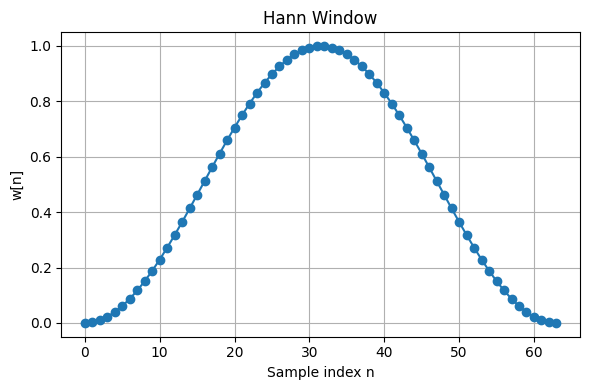

In [5]:
# Plotting an example of Hann window
L = 64  # window length
w = hann_window(L)

plt.figure(figsize=(6, 4))
plt.plot(w, marker="o")
plt.title("Hann Window")
plt.xlabel("Sample index n")
plt.ylabel("w[n]")
plt.grid(True)
plt.tight_layout()
plt.show()

## Manual Implementation of Welch Function
- Below is the manual implementation of the Welch function
- Let's go through a step-by-step for this.

In [7]:
def welch_manual(
    x: np.ndarray,
    fs: float,
    nperseg: int = 256,
    noverlap: int = 0,
    detrend: bool = True,
    window: str = "hann",
) -> tuple[np.ndarray, np.ndarray]:
    """
    Manual Welch PSD estimate (like scipy.signal.welch, but implemented from scratch).

    Args:
        x: signal shape (N,) or (C, N) where C=channels
        fs: sampling rate in Hz
        nperseg: segment length (L)
        noverlap: number of overlapping samples (default: L//2)
        detrend: subtract mean per segment
        window: currently supports "hann" or "rect"

    Returns:
        freqs: (F,) frequency bins from 0..fs/2
        psd: (F,) if input was (N,), else (C, F)
             Units ~ (signal_units^2 / Hz) ("density" scaling).
    """
    x = np.asarray(x, dtype=float)

    # Promote 1D to 2D for uniform handling
    one_dim = (x.ndim == 1)
    if one_dim:
        x = x[None, :]  # (1, N)
    elif x.ndim != 2:
        raise ValueError("x must be shape (N,) or (C, N)")

    # Shape of the input
    C, N = x.shape
    L = int(nperseg)
    if L <= 0 or L > N:
        raise ValueError(f"nperseg must be in [1, N]; got nperseg={L}, N={N}")

    # Check if there is overlap
    if noverlap is None:
        noverlap = L // 2
    noverlap = int(noverlap)
    if not (0 <= noverlap < L):
        raise ValueError("noverlap must satisfy 0 <= noverlap < nperseg")

    # Calculate step size
    step = L - noverlap
    if step <= 0:
        raise ValueError("step must be > 0 (choose smaller noverlap)")

    # Window depending on type
    # Let's assume the Hann is preferred
    if window.lower() in ("hann", "hanning"):
        w = hann_window(L)
    elif window.lower() in ("rect", "boxcar", "rectangular"):
        w = np.ones(L, dtype=float)
    else:
        raise ValueError("window must be 'hann' or 'rect'")

    # Normalization factor for PSD "density" scaling
    # For density scaling, PSD ~= |FFT|^2 / (fs * sum(w^2))
    U = np.sum(w**2)

    # Frequency bins for rFFT
    freqs = np.fft.rfftfreq(L, d=1.0/fs)  # (F,)
    F = freqs.shape[0]

    # Accumulate periodograms
    psd_accum = np.zeros((C, F), dtype=float)
    n_segs = 0

    for start in range(0, N - L + 1, step):
        seg = x[:, start:start+L]  # (C, L)

        if detrend:
            seg = seg - seg.mean(axis=1, keepdims=True)

        segw = seg * w[None, :]  # apply window (C, L)

        # rFFT along time axis
        X = np.fft.rfft(segw, axis=1)  # (C, F)

        # Periodogram (power spectrum)
        Pxx = (np.abs(X) ** 2) / (fs * U)  # (C, F)

        # One-sided correction (except DC and Nyquist if present)
        # This makes total power match the two-sided spectrum energy.
        if L % 2 == 0:
            # even L includes Nyquist bin at -fs/2 mirrored
            Pxx[:, 1:-1] *= 2.0
        else:
            # odd L has no Nyquist bin
            Pxx[:, 1:] *= 2.0

        psd_accum += Pxx
        n_segs += 1

    if n_segs == 0:
        raise RuntimeError("Not enough data for even one segment. Increase signal length or reduce nperseg.")

    psd = psd_accum / n_segs  # average

    # Return shape like scipy: (F,) for 1D input, else (C, F)
    if one_dim:
        return freqs, psd[0]
    return freqs, psd

- Let the following variables be defined:
  - $N$ is input signal length (discretized)
  - $L$ is segment length
  - $O$ is overlap length
  - $S = L-O$ step-size
  - $f_s$ is sampling rate
- Your input $X$ is a multi-channel: $x \in \mathbb{R}^{C \times N}$, if 1D then $C = 1$
- Remember that the goal of Welch is to estimate the power spectral density (PSD) $P_{xx}(f)$

- Step 1: Input handling
  - Make 1D look like multichannel
  - It's done by the code:
```python
      x = np.asarray(x, dtype=float)

      # Promote 1D to 2D for uniform handling
      one_dim = (x.ndim == 1)
      if one_dim:
          x = x[None, :]  # (1, N)
      elif x.ndim != 2:
          raise ValueError("x must be shape (N,) or (C, N)")
```
  - If `x` shape is `(N,1)` this makes it `(1,N)` so that it is similar to a "multichannel" `(C,N)`

- Step 2: Validate parameters and compute step-size
```python
        C, N = x.shape
        L = int(nperseg)
        if L <= 0 or L > N:
            raise ValueError(f"nperseg must be in [1, N]; got nperseg={L}, N={N}")

        if noverlap is None:
            noverlap = L // 2
        noverlap = int(noverlap)
        if not (0 <= noverlap < L):
            raise ValueError("noverlap must satisfy 0 <= noverlap < nperseg")

        step = L - noverlap
        if step <= 0:
            raise ValueError("step must be > 0 (choose smaller noverlap)")
```

- Step 3: Build window function and get the power of the function
```python
        w = hann_window(L)  # or ones(L) for rectangular
        U = np.sum(w**2)
```
  - It computes the Hann window just like mentioned earlier.
  - Also computes:
$$ U = \sum_{n=0}^{L-1}w[n]^2$$
  - The $U$ is the window power normalization use in PSD scaling later.

- Step 4: Setup frequency bings for a one-sided FFT
```python
        freqs = np.fft.rfftfreq(L, d=1.0/fs)
```
- Frequency bins are:
$$ f_k = \frac{k}{L}f_s, \ \ k=0,...,\lfloor\frac{L}{2}\rfloor $$
- Note that `rfft` only returns real signals (excludes the complex)
- Also note that `freqs.shape == (F,)` where $F = L/2 + 1$ so if $L=128$, then $F=65$

- Step 5: Initialize accumulator for averaged period-grams
```python
        psd_accum = np.zeros((C, F))
        n_segs = 0
```

- Step 6: Slide across the signal to extract overlapping segments:
```python
    for start in range(0, N - L + 1, step):
        seg = x[:, start:start+L]  # (C, L)
```
- What happens is that:
$$x_c^{(m)}[n] = x_c [\textrm{start}_m + n],  \ \ n=0, ..., L-1$$
- With $\textrm{start}_m = mS$ and recall that $S$ is step size earlier $S = O - L$


- Step 7: (Optional) Detrending to take out the low-frequency mean
```python
    if detrend:
        seg = seg - seg.mean(axis=1, keepdims=True)
```
- Mathematically:
$$ \tilde{x}_c^{(m)}[n] = x_c^{(m)}[n] - \frac{1}{L} \sum_{n=0}^{L-1}x_c^{(m)}[n]$$

- Step 8: Apply the Hann window on every channel:
```python
        segw = seg * w[None, :]  # (C, L)
```
- Mathematically an element-wise multiplication:
$$x_{w,c}^{(m)}[n] = \tilde{x}_c^{(m)} \cdot w[n] $$

- Step 9: FFT each windowed segment (ons-sided)
```python
        X = np.fft.rfft(segw, axis=1)  # (C, F)
```
- Mathematically:
$$X_c^{(m)}[k] = \sum_{n=0}^{L-1} x_{w,c}^{(m)}[n]e^{\frac{-j2\pi k n}{L}} $$
- This is done only for $k = 0,...,L/2$
- $X_c$ is of size $(C,F)$

- Step 10: Convert FFT magnitudes to a PSD (periodgram) with "density" scaling
```python
        Pxx = (np.abs(X) ** 2) / (fs * U)  # (C, F)
```
- First, numerator gives mangitude squared per freuqnecy bin:
$$|X_c^{(m)}[k]|^2$$
- Then it gets scaled to get PSD density:
$$P_{xx,c}^{(m)}[k] = \frac{|X_c^{(m)}[k]|^2}{f_sU}$$
- Units becomes $x^2/Hz$

- Step 11: One-sided correction
```python
        if L % 2 == 0:
            Pxx[:, 1:-1] *= 2.0
        else:
            Pxx[:, 1:] *= 2.0
```
- You need to double the bins because positive frequency bins are only **half** of the energy.
- Multiplying 2 makes the one-sided PSD preserve the correct power.
- Note that the DC and the nyquist frequencies would already be double, so we need to skip them.
- Even L case: there is a nyquist at $L/2$ and the DC $[0]$ should not be doubled.
- Odd L case: There is no nyquist bin so just make sure the DC $[0]$ is not doubled.

- Step 12: Accumulate and count segments:
```python
        psd_accum += Pxx
        n_segs += 1
```
- We are computing:
$$\sum_{m=1}^M P_{xx}^{(m)}[k] $$

- Step 13: Average across the segments:
```python
        psd = psd_accum / n_segs
```
- Mathematically:
$$\hat{P}_{xx}[k] = \frac{1}{M} \sum_{m=1}^M P_{xx}^{(m)} [k] $$

- Step 14: Return shapes if needed
```python
        if one_dim:
            return freqs, psd[0]
        return freqs, psd
```

## Example Usage of the Manual Welch
- Below is an example usage of the manual welch function

In [15]:
fs = 100.0
t = np.arange(0, 2.0, 1/fs)
x = np.sin(2*np.pi*10*t) + 0.5*np.random.randn(len(t))

freqs, psd = welch_manual(x, fs=fs, nperseg=128, noverlap=64, window="hann")

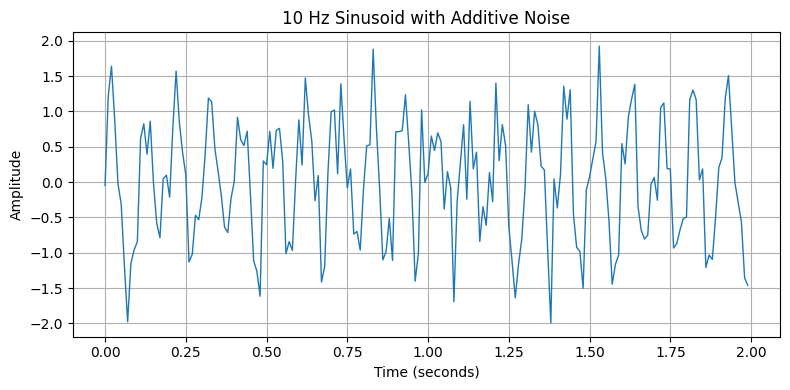

In [11]:
# Plot of the sinusoid
plt.figure(figsize=(8, 4))
plt.plot(t, x, linewidth=1)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("10 Hz Sinusoid with Additive Noise")
plt.grid(True)
plt.tight_layout()
plt.show()

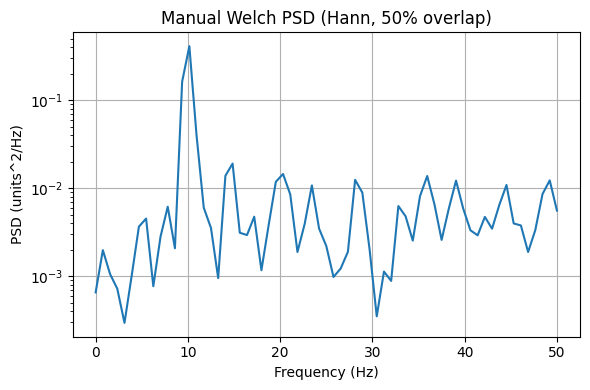

In [16]:
# Plot of the PSD
plt.figure(figsize=(6, 4))
plt.semilogy(freqs, psd)
plt.title("Manual Welch PSD (Hann, 50% overlap)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (units^2/Hz)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Multi-Channel Example
- The above example was for a single channel only (1 signal)
- We use the Welch in our BCI example for a multi-channel
- Below is a nice program for demonstration

In [17]:
# Sampling parameters
fs = 100.0  # Hz
t = np.arange(0, 2.0, 1/fs)

# Three channels with different frequencies
x_ch1 = np.sin(2 * np.pi * 8 * t)    # 8 Hz
x_ch2 = np.sin(2 * np.pi * 12 * t)   # 12 Hz
x_ch3 = np.sin(2 * np.pi * 20 * t)   # 20 Hz

# Add noise independently to each channel
rng = np.random.default_rng(0)
x_ch1 += 0.5 * rng.standard_normal(len(t))
x_ch2 += 0.5 * rng.standard_normal(len(t))
x_ch3 += 0.5 * rng.standard_normal(len(t))

# Stack into (C, N) array — exactly like EEG data
X = np.vstack([x_ch1, x_ch2, x_ch3])

print("X shape:", X.shape)  # (3, N)

X shape: (3, 200)


- In the above channel you should see that there are 3 distinct frequencies
- 8 Hz, 12, Hz, and 20 Hz
- Below roughly visualizes it

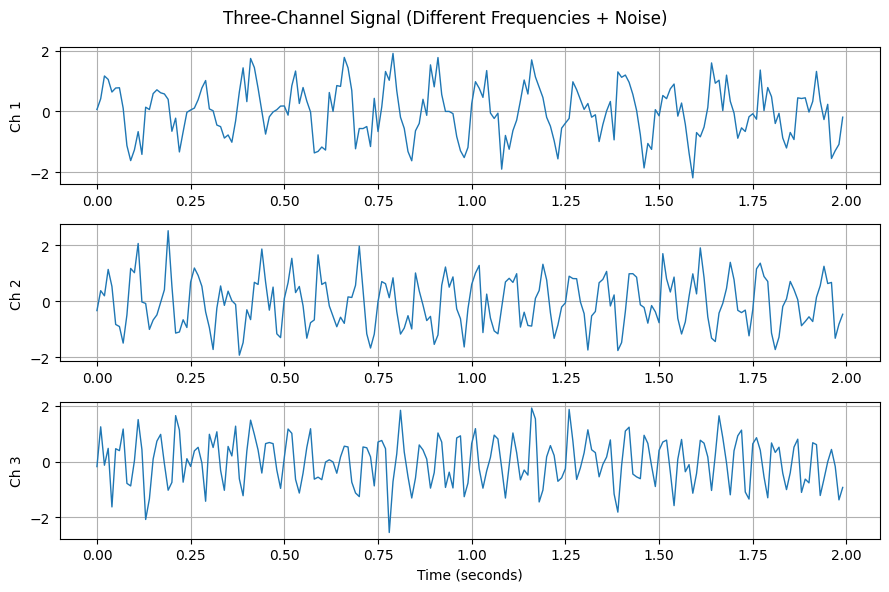

In [18]:
plt.figure(figsize=(9, 6))

for c in range(3):
    plt.subplot(3, 1, c + 1)
    plt.plot(t, X[c], linewidth=1)
    plt.ylabel(f"Ch {c+1}")
    plt.grid(True)

plt.xlabel("Time (seconds)")
plt.suptitle("Three-Channel Signal (Different Frequencies + Noise)")
plt.tight_layout()
plt.show()


- Doing the welch filter below should produce 3 distinct powers in the frequency domain

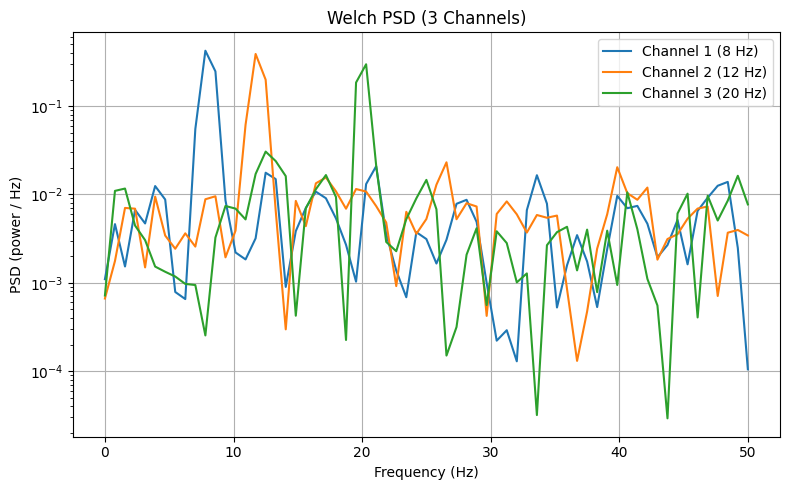

In [23]:
freqs, psd = welch_manual(X, fs=fs, nperseg=128)

plt.figure(figsize=(8, 5))

plt.semilogy(freqs, psd[0], label="Channel 1 (8 Hz)")
plt.semilogy(freqs, psd[1], label="Channel 2 (12 Hz)")
plt.semilogy(freqs, psd[2], label="Channel 3 (20 Hz)")

plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (power / Hz)")
plt.title("Welch PSD (3 Channels)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()